In [75]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from itertools import product, combinations
import math
from utils import save_rectangle_room, save_feature
import os

ImportError: cannot import name 'save_feature'

In [66]:
def getvec(Width, Length, Height):
    return [Width, Length, Height]

def getdir(Distance, Azimuth, Elevation):
    return [Distance, np.deg2rad(Azimuth), np.deg2rad(Elevation)]

In [34]:

dim_slider = interactive(getvec, Width=(2,10,0.1), Length=(2,10,0.1), Height=(2,10,0.1))
print('Please choose room dimensions:')
display(dim_slider)


Please choose room dimensions:


interactive(children=(FloatSlider(value=6.0, description='Width', max=10.0, min=2.0, step=0.5), FloatSlider(va…

In [39]:
dims = dim_slider.result
print('Chosen room dimensions: {}'.format(dims))

offset = 0.5
lis_slider = interactive(getvec, Width=(offset,dims[0]-offset,0.1), Length=(offset,dims[1]-offset,0.1), Height=(offset,dims[2]-offset,0.1))
print('Please choose listener location:')
display(lis_slider)

Chosen room dimensions: [6.0, 6.0, 6.0]
Please choose listener location:


interactive(children=(FloatSlider(value=3.0, description='Width', max=5.5, min=0.5), FloatSlider(value=3.0, de…

In [59]:
src_slider = interactive(getdir, Distance=(1,np.max(dims),0.1), Azimuth=(0,360,0.1), Elevation=(-90,90,0.1))
print('Please choose source direction:')
display(src_slider)

Please choose source direction:


interactive(children=(FloatSlider(value=3.5, description='Distance', max=6.0, min=1.0), FloatSlider(value=180.…

In [67]:
lis_loc = lis_slider.result
src_dir = src_slider.result
r = src_dir[0]
phi = src_dir[1]
theta = src_dir[2]
src_loc = [ lis_loc[0] + r * math.sin(theta) * math.cos(phi),
            lis_loc[1] + r * math.sin(theta) * math.sin(phi),
            lis_loc[2] + r * math.cos(theta)]
print('source location: {}, listener location: {}'.format(src_loc, lis_loc))

source location: [2.9329003958915907, 3.9360877480434797, 4.652040366059916], listener location: [3.0, 3.0, 3.0]


<IPython.core.display.Javascript object>


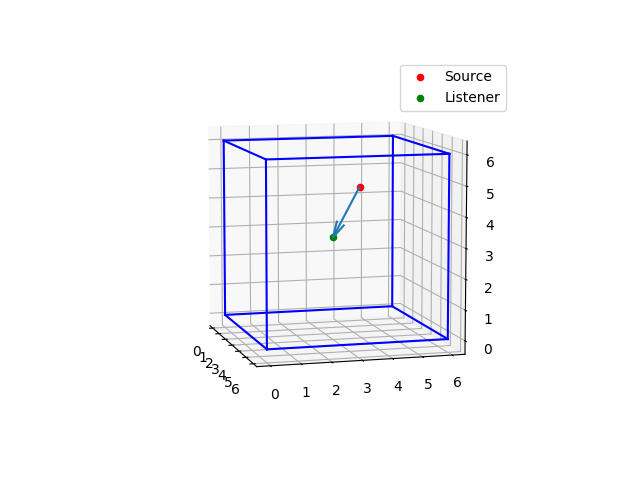

In [71]:

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
for s, e in combinations(np.array(list(product([0, dims[0]], [0, dims[1]], [0, dims[2]]))), 2):
    if np.sum(np.abs(s-e)) in dims:
        ax.plot3D(*zip(s, e), color="b")
        
ax.quiver(src_loc[0],src_loc[1],src_loc[2],lis_loc[0]-src_loc[0],lis_loc[1]-src_loc[1],lis_loc[2]-src_loc[2],arrow_length_ratio=0.3)
ax.scatter(src_loc[0],src_loc[1],src_loc[2], c='r', label='Source')
ax.scatter(lis_loc[0],lis_loc[1],lis_loc[2], c='g', label='Listener')
ax.legend()
plt.show()

In [70]:
working_dir = 'data'
speech_path = 'data/84-121123-0000.flac'
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
obj_path = os.path.join(working_dir, 'room.obj')
save_rectangle_room(dims, obj_path)
feature_path = None
while not feature_path:    
    feature_path = save_feature(obj_path, speech_path, src_loc, lis_loc)
